In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.measure import block_reduce
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
in_dir = 'dataset2-master/dataset2-master/images'

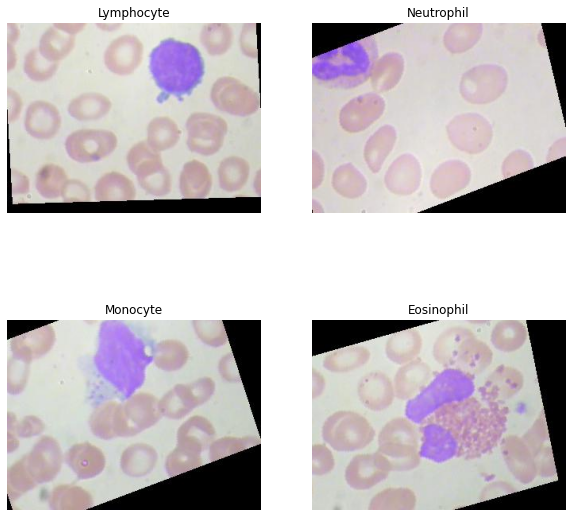

<Figure size 864x576 with 0 Axes>

In [24]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
def plotImage(h,w,image_path,title):
    image = cv2.imread(image_path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    axes[w,h].imshow(image)
    axes[w,h].axis('off')
    axes[w,h].set_title(title)
    
plt.figure(figsize=(12,8))
lymp_path = os.path.join(in_dir, 'TRAIN/LYMPHOCYTE') 
mono_path = os.path.join(in_dir, 'TRAIN/MONOCYTE')
neu_path = os.path.join(in_dir, 'TRAIN/NEUTROPHIL')
eos_path = os.path.join(in_dir, 'TRAIN/EOSINOPHIL')
plotImage(0,0,os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),'Lymphocyte')
plotImage(0,1,os.path.join(mono_path, random.choice(os.listdir(mono_path))),'Monocyte')
plotImage(1,0,os.path.join(neu_path, random.choice(os.listdir(neu_path))),'Neutrophil')
plotImage(1,1,os.path.join(eos_path, random.choice(os.listdir(eos_path))),'Eosinophil')
plt.tight_layout()
plt.show()

Total Train samples: 9957

Total Test samples: 2487



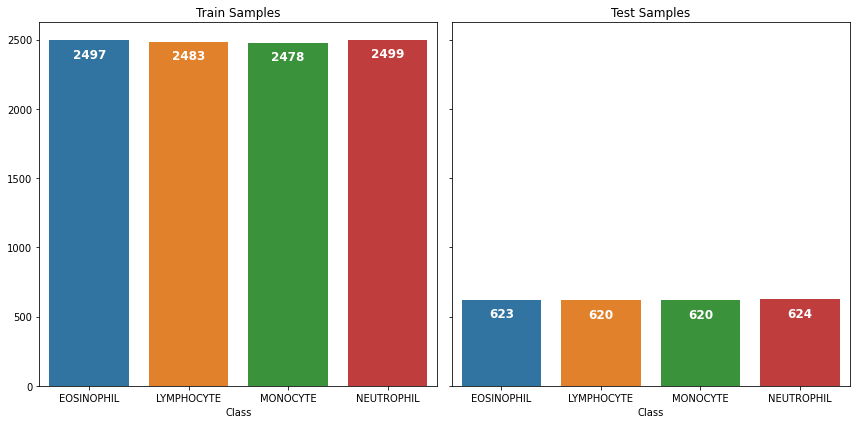

In [25]:
train_dir = os.path.join(in_dir, "TRAIN")
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
def plot_num_samples(path, s, ax):
    x = []
    y = []
    num_samples = 0
    for cls in os.listdir(path):
        num_imgs = len(os.listdir(os.path.join(path, cls)))
        num_samples += num_imgs
        x.append(cls)
        y.append(num_imgs)

    print('Total ' + s + ' samples: {:d}\n'.format(num_samples))
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_xlabel('Class')
    ax.set_title(s + ' Samples')
    for index, value in enumerate(y):
        ax.text(index, value-150, str(value), ha='center', va='bottom', color='white',weight='bold', fontsize=12)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
plot_num_samples(train_dir, "Train", ax1)
plot_num_samples(test_dir, "Test", ax2)
plt.tight_layout()
plt.show()

In [29]:
def equalize_hist_rgb(image):
    # Split the image into color channels
    b, g, r = cv2.split(image)

    # Apply histogram equalization to each channel
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    # Merge the equalized channels back into an RGB image
    equalized_image = cv2.merge([b_eq, g_eq, r_eq])

    return equalized_image

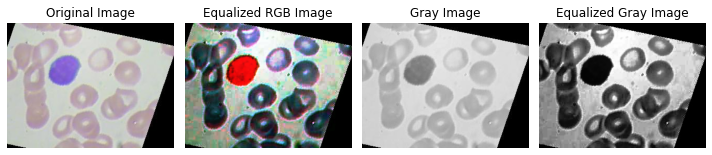

In [30]:
random_file = random.choice(os.listdir(lymp_path))
image = cv2.imread(os.path.join(lymp_path, random_file), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join(lymp_path, random_file))
image2 = image2[:, :, [2, 1, 0]]
image3 = cv2.imread(os.path.join(lymp_path, random_file))



# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)
# Display the original and equalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(equalize_hist_rgb(image3))
plt.title('Equalized RGB Image')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Gray Image')
plt.axis('off')


plt.tight_layout()
plt.show()

In [65]:
def reduce_plt(df):

    without_label_df = df
    without_label_np = df.to_numpy()
#     my_labels = df.label
    n_colors = 10

    for i in range(len(df)):
        img = without_label_np[i].reshape(24,32,3)
        
        arr = img.reshape((-1, 3))
        kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        less_colors = centers[labels].reshape(img.shape)
        
        ravel_img = less_colors.astype('uint8').ravel()
        without_label_df.loc[i] = ravel_img
    
    return without_label_df

114.25314236111112

In [31]:
def read_resize_img(path, t='RGB'):
    image = cv2.imread(path)  # BGR
    if t == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    elif t == 'GRAY':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(image, (160, 120))
    return resized_image

In [40]:
def create_sub_df(directory_path,num_cls,t='RGB'):
    if t == 'RGB':
        images = np.ndarray((len(os.listdir(directory_path)),120*160*3), dtype=np.uint8)
    elif t == 'GRAY':
        images = np.ndarray((len(os.listdir(directory_path)),120*160), dtype=np.uint8)
    i=0
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        resized_image = read_resize_img(file_path,t)
        images[i,:] = resized_image.ravel()
        i+=1
    df = pd.DataFrame(images)
    df["target"] = num_cls
    return df

def create_df(directory_path,t='RGB'):
    clss = []
    for cls in os.listdir(directory_path):
        if str(cls) == "MONOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),1,t))
        elif str(cls) == "LYMPHOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),2,t))
        elif str(cls) == "NEUTROPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),3,t))
        elif str(cls) == "EOSINOPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),4,t))
    df = pd.concat(clss)
    return shuffle(df).reset_index(drop=True)

In [33]:
df_train = create_df(train_dir)
df_test = create_df(test_dir)

### PCA

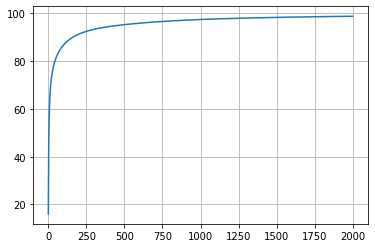

In [75]:
pca = PCA(n_components=2000)
pca.fit(df_train)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.savefig('pca.png')

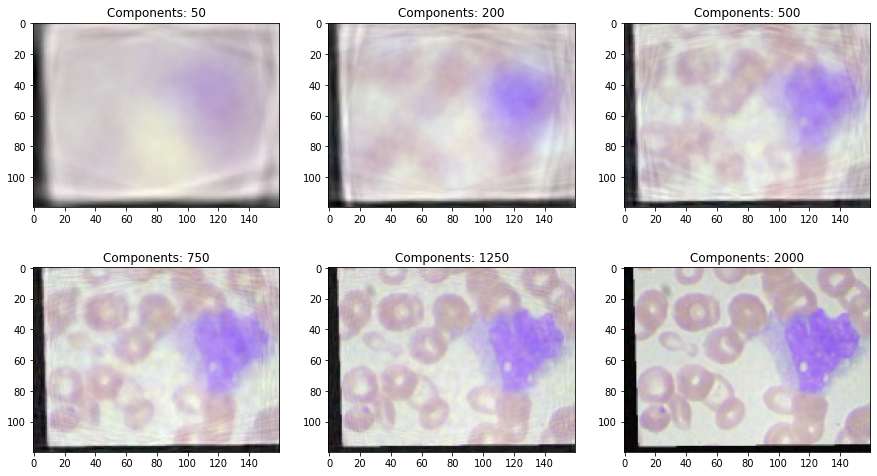

In [38]:
def plot_at_k(k):
    pca = PCA(n_components=k)
    x = df_first_2500.iloc[:, :-1]
    x = x.astype(float) / 255
    x = pca.fit_transform(x)
    dff = pd.DataFrame(pca.inverse_transform(x))
    image = np.array(dff.iloc[3, :]).reshape((120, 160, 3))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Scale values between 0 and 1
    image = (image * 255).astype(np.uint8)  # Scale values between 0 and 255
    plt.imshow(image)

    
ks = [50, 200, 500, 750, 1250, 2000]
df_first_2500 = df_train.head(2500)
plt.figure(figsize=[15, 9])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plot_at_k(ks[i])
    plt.title("Components: " + str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()

In [110]:
pca = PCA(n_components=2000)
df_train_reconstructed_pca = pca.inverse_transform(pca.fit_transform(df_train.iloc[:, :-1]))
df_test_reconstructed_pca = pca.inverse_transform(pca.transform(df_test.iloc[:, :-1]))

In [114]:
df_train_reconstructed_pca = pd.DataFrame(df_train_reconstructed_pca)
df_test_reconstructed_pca = pd.DataFrame(df_test_reconstructed_pca)

In [25]:
def max_pooling(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160, 3)
        max_pool = block_reduce(img, block_size=(5, 5, 1), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df

In [122]:
df_train_max_pool = max_pooling(pd.DataFrame(df_train_reconstructed_pca))
df_test_max_pool = max_pooling(pd.DataFrame(df_test_reconstructed_pca))

Text(0.5, 1.0, '1.8601804555905268')

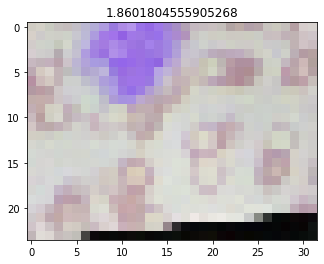

In [88]:
img = df_train_max_pool.iloc[2, :-1] / 255
plt.imshow(np.array(img).reshape(24, 32, 3))


In [124]:
df_train_max_pool = df_train_max_pool.join(df_train.iloc[:, -1])
df_test_max_pool = df_test_max_pool.join(df_test.iloc[:, -1])

In [126]:
df_train_max_pool.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv', index=False)
df_test_max_pool.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv', index=False)

In [2]:
df_train_max_pool = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv')
df_test_max_pool = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv')

In [ ]:
from skimage import io
from sklearn.cluster import KMeans

# Models


In [3]:
def plot_confusion_matrix(model, X_train, y_train, X_test, y_test):
    labels = ["Monocyte", "Lymphocyte", "Neutrophil", "Eosinophil"]
    model.fit(X_train, y_train)
    
    # Model prediction
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", accuracy)
    print()
    print(classification_report(y_test, y_pred, labels=range(1,len(labels)+1), target_names=labels))
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax, linewidths=1)
    
    # Set labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    
    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    # Show the plot
    plt.show()

In [77]:
X_train, y_train = df_train_max_pool.iloc[:, :-1], df_train_max_pool.iloc[:, -1]
X_test, y_test = df_test_max_pool.iloc[:, :-1], df_test_max_pool.iloc[:, -1]

### Scaling

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KNN

In [9]:
k_range = list(range(1, 20, 1))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

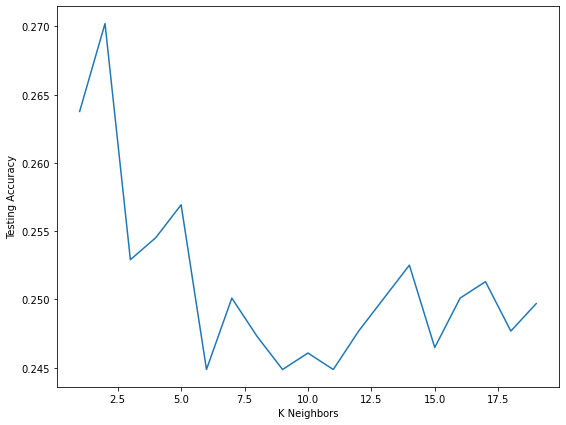

In [10]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 0.8052626293060159
Testing Accuracy: 0.27020506634499397

              precision    recall  f1-score   support

    Monocyte       0.25      0.36      0.30       620
  Lymphocyte       0.36      0.19      0.25       620
  Neutrophil       0.26      0.47      0.33       624
  Eosinophil       0.27      0.06      0.10       623

    accuracy                           0.27      2487
   macro avg       0.29      0.27      0.24      2487
weighted avg       0.29      0.27      0.24      2487



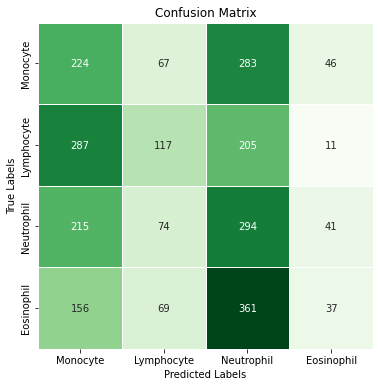

In [11]:
plot_confusion_matrix(KNeighborsClassifier(n_neighbors=2), X_train, y_train, X_test, y_test)

**The accuracy result of KNN is almost no better than a dummy model predicted by randomness.**

KNN is generally not well-suited for classifying images, especially in cases where the images have complex variations and noise (as our case). Here are some reasons why KNN may struggle to succeed in image classification:

1. High-dimensional feature space: Images are represented by high-dimensional feature vectors, with each dimension corresponding to a pixel or a set of features. In high-dimensional spaces, the notion of distance becomes less meaningful, and the curse of dimensionality can lead to sparsity and increased computational complexity. This makes it challenging for KNN to accurately measure the similarity between images based on their feature vectors.

2. Sensitivity to irrelevant features: Images often contain a large number of irrelevant or noisy features that can hinder classification accuracy. KNN treats all features equally, which means it considers both relevant and irrelevant features during classification. This sensitivity to irrelevant features can lead to inaccurate results, especially when the noise or irrelevant features dominate the classification decision.

3. Lack of spatial information: KNN does not consider the spatial relationships and structural information present in images. It treats each pixel or feature independently without considering the arrangement or context of neighboring pixels. This can make it difficult for KNN to capture the meaningful spatial dependencies and patterns necessary for accurate image classification.

### Logistic Regression

Training Accuracy: 0.7283318268554786
Testing Accuracy: 0.3988741455568959

              precision    recall  f1-score   support

    Monocyte       0.55      0.60      0.57       620
  Lymphocyte       0.44      0.33      0.38       620
  Neutrophil       0.31      0.36      0.33       624
  Eosinophil       0.32      0.32      0.32       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.40      2487
weighted avg       0.40      0.40      0.40      2487



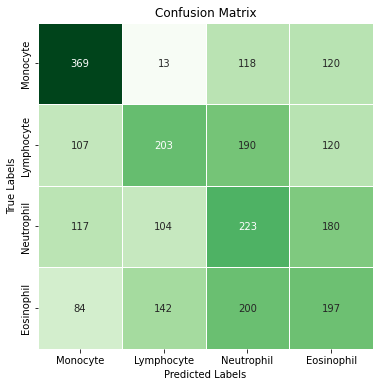

In [12]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7446017876870543
Testing Accuracy: 0.3956574185765983

              precision    recall  f1-score   support

    Monocyte       0.53      0.57      0.55       620
  Lymphocyte       0.44      0.32      0.37       620
  Neutrophil       0.31      0.38      0.34       624
  Eosinophil       0.32      0.31      0.31       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.39      2487
weighted avg       0.40      0.40      0.39      2487



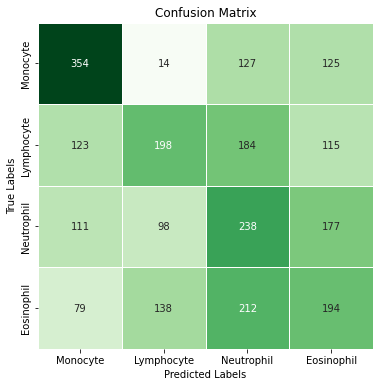

In [13]:
plot_confusion_matrix(LogisticRegression(max_iter=4000), X_train, y_train, X_test, y_test)

### SVM

Training Accuracy: 0.8501556693783268
Testing Accuracy: 0.3220747889022919

              precision    recall  f1-score   support

    Monocyte       0.76      0.14      0.24       620
  Lymphocyte       0.71      0.23      0.35       620
  Neutrophil       0.27      0.66      0.38       624
  Eosinophil       0.26      0.26      0.26       623

    accuracy                           0.32      2487
   macro avg       0.50      0.32      0.31      2487
weighted avg       0.50      0.32      0.31      2487



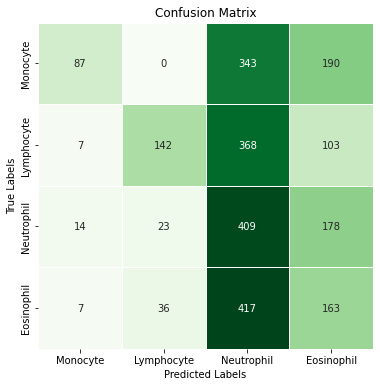

In [15]:
plot_confusion_matrix(SVC(C=0.5,kernel='poly'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.6440694988450336
Testing Accuracy: 0.4338560514676317

              precision    recall  f1-score   support

    Monocyte       0.70      0.58      0.63       620
  Lymphocyte       0.52      0.38      0.44       620
  Neutrophil       0.35      0.48      0.40       624
  Eosinophil       0.28      0.30      0.29       623

    accuracy                           0.43      2487
   macro avg       0.46      0.43      0.44      2487
weighted avg       0.46      0.43      0.44      2487



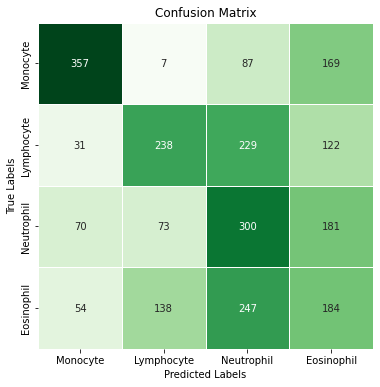

In [14]:
plot_confusion_matrix(SVC(C=0.25,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7921060560409762
Testing Accuracy: 0.44189786891837557

              precision    recall  f1-score   support

    Monocyte       0.72      0.55      0.63       620
  Lymphocyte       0.58      0.42      0.48       620
  Neutrophil       0.33      0.51      0.40       624
  Eosinophil       0.29      0.29      0.29       623

    accuracy                           0.44      2487
   macro avg       0.48      0.44      0.45      2487
weighted avg       0.48      0.44      0.45      2487



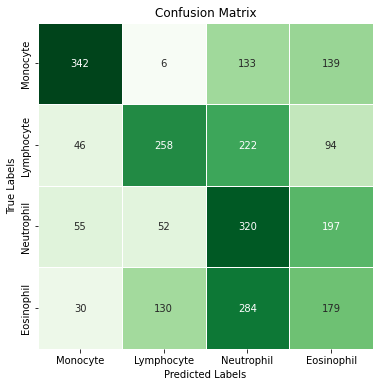

In [16]:
plot_confusion_matrix(SVC(C=0.5,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.9129255799939741
Testing Accuracy: 0.43104141535987134

              precision    recall  f1-score   support

    Monocyte       0.75      0.49      0.59       620
  Lymphocyte       0.60      0.43      0.50       620
  Neutrophil       0.33      0.54      0.41       624
  Eosinophil       0.27      0.27      0.27       623

    accuracy                           0.43      2487
   macro avg       0.49      0.43      0.44      2487
weighted avg       0.49      0.43      0.44      2487



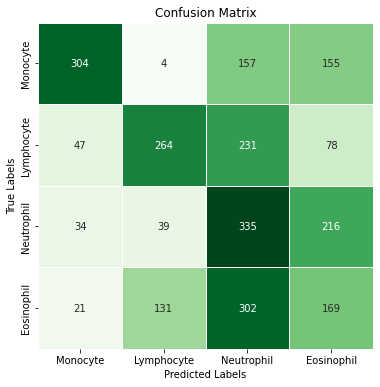

In [17]:
plot_confusion_matrix(SVC(C=1,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.4189786891837555

              precision    recall  f1-score   support

    Monocyte       0.71      0.45      0.55       620
  Lymphocyte       0.59      0.39      0.47       620
  Neutrophil       0.32      0.54      0.40       624
  Eosinophil       0.29      0.30      0.30       623

    accuracy                           0.42      2487
   macro avg       0.48      0.42      0.43      2487
weighted avg       0.48      0.42      0.43      2487



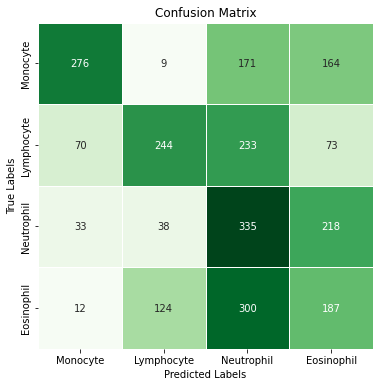

In [18]:
plot_confusion_matrix(SVC(C=10,kernel='rbf'), X_train, y_train, X_test, y_test)

### Decision Tree and Random Forest

Training Accuracy: 1.0
Testing Accuracy: 0.3333333333333333

              precision    recall  f1-score   support

    Monocyte       0.41      0.36      0.38       620
  Lymphocyte       0.38      0.32      0.35       620
  Neutrophil       0.29      0.35      0.32       624
  Eosinophil       0.29      0.30      0.29       623

    accuracy                           0.33      2487
   macro avg       0.34      0.33      0.33      2487
weighted avg       0.34      0.33      0.33      2487



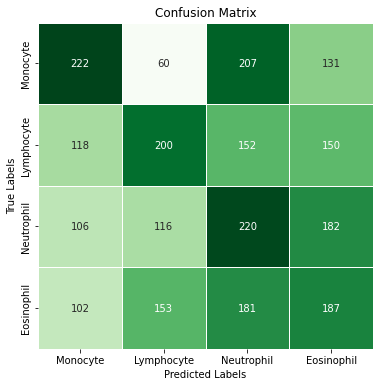

In [19]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0), X_train, y_train, X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.44310414153598715

              precision    recall  f1-score   support

    Monocyte       0.73      0.56      0.64       620
  Lymphocyte       0.48      0.39      0.43       620
  Neutrophil       0.35      0.50      0.41       624
  Eosinophil       0.32      0.31      0.32       623

    accuracy                           0.44      2487
   macro avg       0.47      0.44      0.45      2487
weighted avg       0.47      0.44      0.45      2487



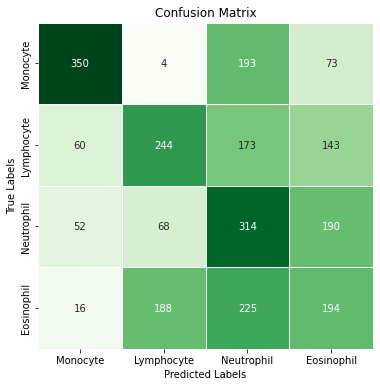

In [20]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), X_train , y_train , X_test, y_test)

### Voting

Training Accuracy: 0.9146329215627197
Testing Accuracy: 0.4571773220747889

              precision    recall  f1-score   support

    Monocyte       0.65      0.66      0.65       620
  Lymphocyte       0.52      0.43      0.47       620
  Neutrophil       0.35      0.46      0.40       624
  Eosinophil       0.33      0.28      0.30       623

    accuracy                           0.46      2487
   macro avg       0.46      0.46      0.46      2487
weighted avg       0.46      0.46      0.46      2487



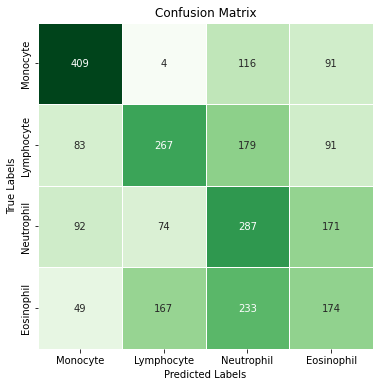

In [21]:
clf1 = LogisticRegression(solver='liblinear')
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(C=0.5,kernel='rbf')
vot = VotingClassifier(estimators=[ ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
plot_confusion_matrix(vot, X_train, y_train, X_test, y_test)

### Neural Network - CNN

In [33]:
X_train_s, y_train_s = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test_s, y_test_s = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_test_s, X_val, y_test_s, y_val = train_test_split(X_test_s, y_test_s, test_size = 0.5)

In [36]:
reshaped_X_train = X_train_s.to_numpy().reshape((9957, 120, 160, 3))
reshaped_X_test = X_test_s.to_numpy().reshape((1243, 120, 160, 3))
reshaped_X_val = X_val.to_numpy().reshape((1244, 120, 160, 3))

In [38]:
reshaped_X_train_s = reshaped_X_train_s / 255.0 
reshaped_X_val = reshaped_X_val / 255.0
reshaped_X_test_s = reshaped_X_test_s / 255.0

In [56]:
model1 = Sequential()

# First Conv Layer
model1.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,160,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv Layer
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# Third Conv Layer
model1.add(Conv2D(64, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# FC layer
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.25))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Train
history1 = model1.fit(
    reshaped_X_train_s, 
    y_train_s, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(reshaped_X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 158, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 77, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 38, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 36, 64)       

In [64]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(1,len(history.history['accuracy'])+1)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

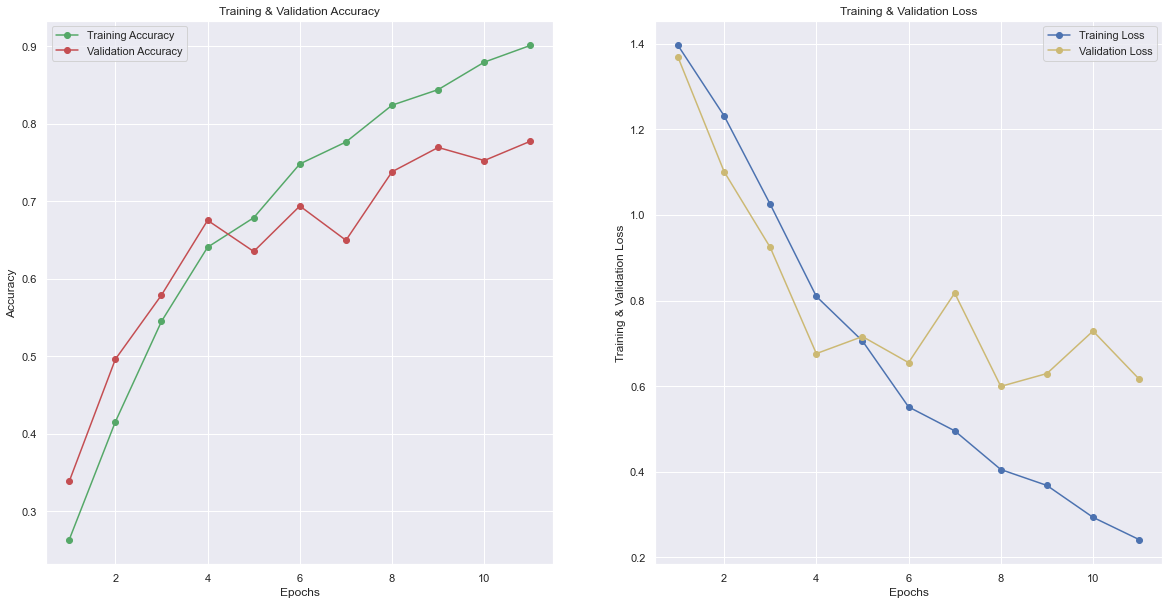

In [65]:
plot_accuracy_loss_chart(history1)


In [61]:
results = model1.evaluate(reshaped_X_test_s, y_test_s)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")

39/39 [==============================] - 4s 110ms/step - loss: 0.5940 - accuracy: 0.7836
Loss of the model  is - test  0.5940081477165222
Accuracy of the model is - test 78.35881114006042 %


In [41]:
train_g = create_df(train_dir,'GRAY')
test_g = create_df(test_dir,'GRAY')

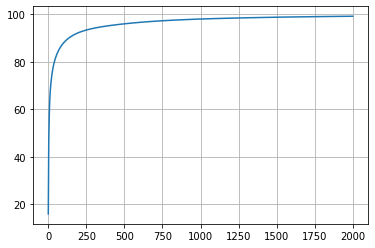

In [42]:
pcag = PCA(n_components=2000)
pcag.fit(train_g)
plt.grid()
plt.plot(np.cumsum(pcag.explained_variance_ratio_*100))
plt.savefig('pcag.png')

In [49]:
pcag = PCA(n_components=1800)
train_g_reconstructed_pca = pd.DataFrame(pcag.inverse_transform(pcag.fit_transform(train_g.iloc[:, :-1])))
test_g_reconstructed_pca =  pd.DataFrame(pcag.inverse_transform(pcag.transform(test_g.iloc[:, :-1])))

In [51]:
train_g_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,19190,19191,19192,19193,19194,19195,19196,19197,19198,19199
0,-6.890106,5.000792,4.247044,1.573128,4.243736,1.741750,1.976746,-3.203094,-5.682110,-9.819745,...,159.648559,164.948698,147.159149,152.302235,166.800257,164.492501,166.143959,174.355189,180.296775,184.642479
1,-2.716993,-3.950549,-1.321650,2.596577,-5.092649,-0.245061,-3.902462,-0.544051,10.365939,3.764448,...,8.910737,8.701534,0.143477,5.426936,1.655473,9.447665,6.304638,4.969201,-6.216543,-6.631142
2,3.170845,-0.908582,-5.236973,-1.155256,6.165492,-3.904099,2.939276,-3.786192,-1.199658,0.902136,...,1.866812,2.371252,-3.149046,-3.484258,6.561219,0.328149,-0.665071,-1.165784,-8.445889,0.174216
3,-6.929646,3.857106,-0.548326,-1.384051,4.546287,0.631538,3.347135,6.033233,-1.064586,-1.310985,...,-4.981916,-3.788866,-6.858030,-3.921853,7.751367,9.913453,9.967316,0.188273,-0.151063,-14.425026
4,1.078378,-3.105955,1.080471,-0.066287,2.895123,1.564430,-5.608698,-3.740128,19.656509,116.704770,...,169.080062,177.797959,162.249870,160.960389,172.454338,173.710050,173.642064,179.428378,171.667489,166.707564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,-2.728363,12.647332,9.176834,34.694300,146.952564,199.768069,195.953520,184.716804,186.267608,187.800611,...,-3.898891,4.302804,4.987204,-0.922303,-5.166621,4.069205,-3.005046,-2.663465,-4.297964,-9.321389
9953,-4.356575,-7.044114,-3.617371,0.446732,-5.719083,10.679764,5.750477,5.662354,9.486614,3.854206,...,-2.089639,2.601855,15.885611,21.311801,36.571900,32.840683,-3.418638,-18.272727,-16.046956,-8.961489
9954,7.980041,10.651975,2.474047,-5.406434,-4.628448,5.181187,3.174728,-5.078890,-9.178896,-0.381380,...,2.320492,10.261111,-1.313058,1.828257,4.462541,-1.647295,-1.461171,-1.745891,-2.508850,8.312508
9955,7.478242,-3.896533,-4.027752,48.393213,179.695607,215.793017,230.061587,228.797752,226.458747,217.194216,...,-0.902636,-3.524191,5.967459,3.431868,4.746373,5.437287,2.030152,5.083878,-1.894681,-4.086381


In [52]:
def max_pooling_g(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160)
        max_pool = block_reduce(img, block_size=(4, 4), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df
train_g_reconstructed_pca = max_pooling_g(train_g_reconstructed_pca)
test_g_reconstructed_pca = max_pooling_g(test_g_reconstructed_pca)

In [54]:
train_g_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,5.439178,10.850500,13.999978,10.061558,6.023897,5.144079,9.798832,10.358887,8.324957,11.393807,...,160.707894,158.745314,161.580984,207.307457,202.252057,188.500275,184.081289,177.749581,189.001084,197.104473
1,4.202878,4.969577,97.373064,198.885751,196.536676,191.943175,197.817866,193.115501,193.738793,194.320229,...,10.165247,13.359526,9.068462,7.439529,7.734718,8.805278,9.996431,10.338266,9.447665,22.310490
2,6.820290,7.827718,6.603892,11.722524,6.647381,87.832671,180.037019,190.378194,187.883006,186.840330,...,3.806177,4.776717,8.808051,2.385092,7.498063,5.552964,3.497621,8.748795,6.561219,5.892817
3,8.161105,6.033233,7.044321,5.517955,5.086511,9.375126,9.369250,8.672075,7.905215,3.724830,...,70.412919,8.346941,16.733411,10.352040,10.245948,3.758244,7.553205,5.354007,13.556017,9.967316
4,9.555541,10.446651,157.693944,159.470574,155.640207,161.832197,192.240380,199.488456,193.554460,163.838187,...,180.853579,205.019809,208.659360,201.875930,187.361167,175.299160,174.345540,179.329296,176.042648,179.428378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,86.012722,211.736287,188.937926,188.757569,217.716572,214.444827,185.147749,196.638431,202.985811,197.064181,...,195.522057,220.537931,220.651283,211.309953,204.621774,206.808400,179.984942,4.302804,9.003175,4.671975
9953,4.186595,10.679764,144.382743,182.624823,199.697115,213.537783,205.435222,172.392465,194.285958,184.971368,...,12.753032,12.614568,4.644965,16.795153,40.227883,117.558265,185.842148,195.094450,206.888045,78.363181
9954,10.651975,29.468560,8.336332,15.748592,82.417073,98.318058,154.571671,162.130818,164.266095,163.105088,...,5.517987,9.514599,8.410866,5.789816,3.462040,11.829861,6.896497,10.261111,8.117823,8.312508
9955,151.233944,232.367847,228.737555,232.059795,228.374768,225.360440,225.162449,218.484906,188.408492,219.142914,...,170.925676,171.545457,204.562150,216.130107,212.359993,8.574784,5.111344,7.622774,9.375381,5.244503


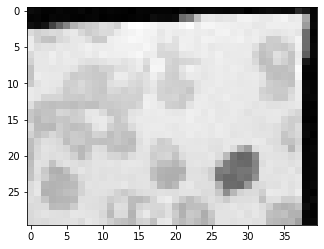

In [56]:
img = train_g_reconstructed_pca.iloc[5, :]

plt.imshow(np.array(img).reshape(30, 40),cmap='gray')
# plt.title(df_train_max_pool.iloc[2, -1])

In [60]:
k_range = list(range(1, 20, 1))
scoresg = []
for k in k_range:
    knng = KNeighborsClassifier(n_neighbors=k)
    knng.fit(train_g_reconstructed_pca, train_g.iloc[:, -1])
    y_pred = knng.predict(test_g_reconstructed_pca)
    scoresg.append(accuracy_score(test_g.iloc[:, -1], y_pred))

Text(0, 0.5, 'Testing Accuracy')

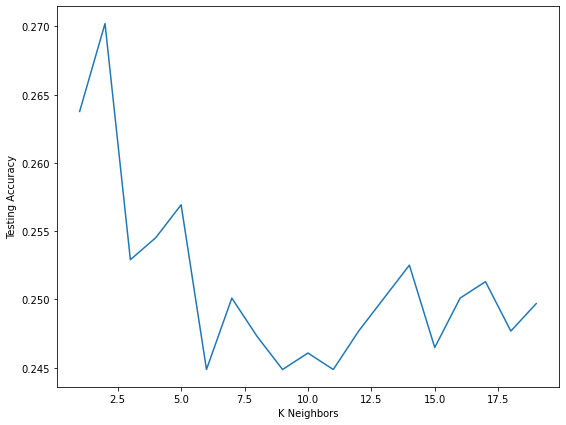

In [61]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 0.4943256000803455
Testing Accuracy: 0.2517088862082831

              precision    recall  f1-score   support

    Monocyte       0.24      0.23      0.24       620
  Lymphocyte       0.29      0.29      0.29       620
  Neutrophil       0.24      0.27      0.25       624
  Eosinophil       0.24      0.22      0.23       623

    accuracy                           0.25      2487
   macro avg       0.25      0.25      0.25      2487
weighted avg       0.25      0.25      0.25      2487



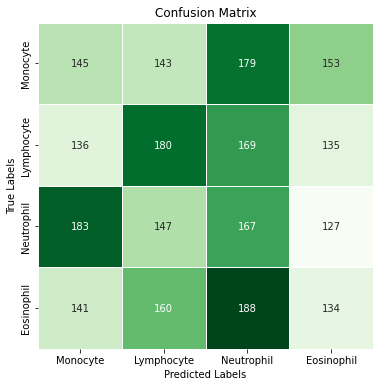

In [62]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), train_g_reconstructed_pca, train_g.iloc[:, -1], test_g_reconstructed_pca, test_g.iloc[:, -1])

In [75]:
from skimage import io
from sklearn.cluster import KMeans
def reduce_plt(df):

    n_colors = 10

    for i in range(len(df)):
        img = df.values[i].reshape(24,32,3)
        
        arr = img.reshape((-1, 3))
        kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        less_colors = centers[labels].reshape(img.shape)
        
        ravel_img = less_colors.astype('uint8').ravel()
        df.loc[i] = ravel_img
    
    return df

In [78]:
X_train = reduce_plt(pd.DataFrame(X_train))

In [85]:
X_test = reduce_plt(pd.DataFrame(X_test))

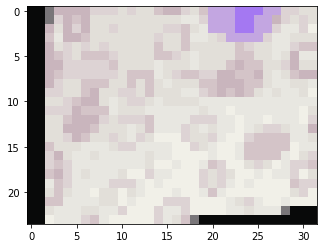

In [84]:
img = X_train.iloc[8, :]
img = img / 255

plt.imshow(np.array(img).reshape(24,32,3))

In [86]:
k_range = list(range(1, 20, 1))
scoresg = []
for k in k_range:
    knng = KNeighborsClassifier(n_neighbors=k)
    knng.fit(X_train, y_train)
    y_pred = knng.predict(X_test)
    scoresg.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

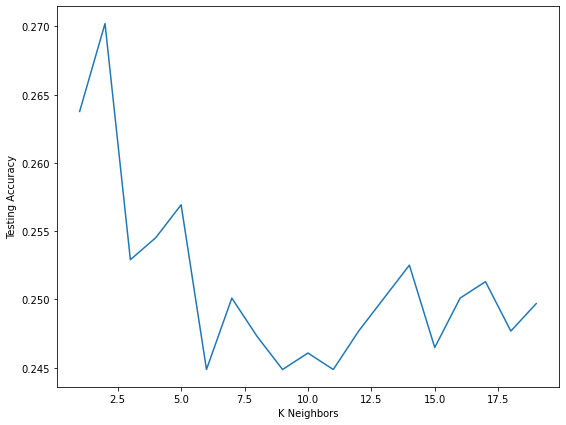

In [87]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

In [88]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training Accuracy: 1.0
Testing Accuracy: 0.4451145958986731

              precision    recall  f1-score   support

    Monocyte       0.79      0.52      0.62       620
  Lymphocyte       0.51      0.38      0.44       620
  Neutrophil       0.36      0.55      0.43       624
  Eosinophil       0.32      0.33      0.32       623

    accuracy                           0.45      2487
   macro avg       0.49      0.45      0.45      2487
weighted avg       0.49      0.45      0.45      2487



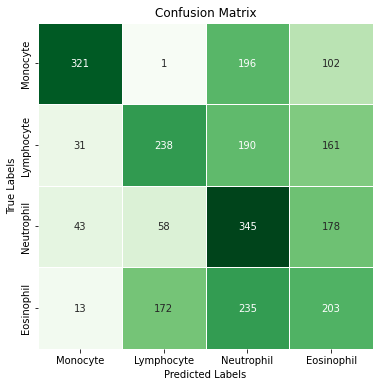

In [89]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), X_train , y_train , X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.3478086047446723

              precision    recall  f1-score   support

    Monocyte       0.49      0.37      0.42       620
  Lymphocyte       0.41      0.36      0.38       620
  Neutrophil       0.30      0.37      0.33       624
  Eosinophil       0.26      0.29      0.28       623

    accuracy                           0.35      2487
   macro avg       0.36      0.35      0.35      2487
weighted avg       0.36      0.35      0.35      2487



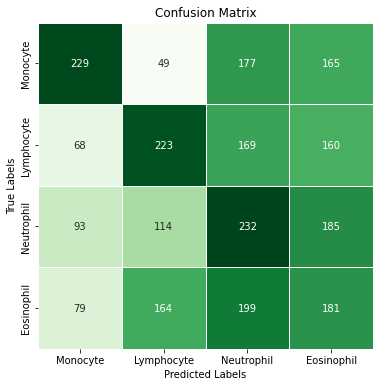

In [90]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0), X_train, y_train, X_test, y_test)

Training Accuracy: 0.909912624284423
Testing Accuracy: 0.42259750703659027

              precision    recall  f1-score   support

    Monocyte       0.78      0.42      0.55       620
  Lymphocyte       0.59      0.45      0.51       620
  Neutrophil       0.32      0.54      0.40       624
  Eosinophil       0.27      0.28      0.28       623

    accuracy                           0.42      2487
   macro avg       0.49      0.42      0.44      2487
weighted avg       0.49      0.42      0.43      2487



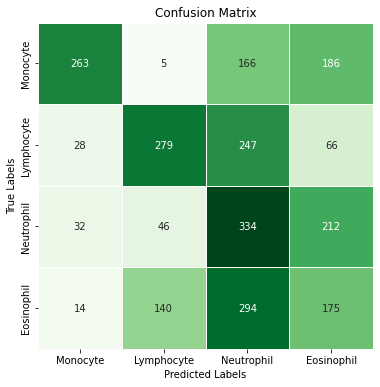

In [92]:
plot_confusion_matrix(SVC(C=1,kernel='rbf'), X_train, y_train, X_test, y_test)